In [16]:
%reload_ext autoreload
%autoreload 2

In [17]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats

import torch.optim as optim
import torch
import torch.nn as nn

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import display,clear_output

import warnings
warnings.filterwarnings("ignore")

In [18]:
from dataset import HelocDataset
from experiments import Benchmarking
from utils.logger_config import setup_logger
from tqdm import tqdm
from models.wrapper import PYTORCH_MODELS

logger = setup_logger()

In [19]:
from dataset import dataset_loader

In [20]:
name = 'heloc'
dataset_ares = dataset_loader(name, data_path='data/', dropped_features=[], n_bins=None)

In [21]:
from experiments.counterfactual import *
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from models import PyTorchDNN, PyTorchLinearSVM, PyTorchRBFNet, PyTorchLogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.gaussian_process import GaussianProcessClassifier

In [26]:
dataset = HelocDataset(dataset_ares=dataset_ares)

input_dim = dataset.get_dataframe().shape[1] - 1
seed = 102
torch.manual_seed(seed)

counterfactual_algorithms = [
    # 'DiCE',
    # 'DisCount',
    # 'GlobeCE'
    'AReS',
    'KNN',
]

experiment = Benchmarking(
    dataset=dataset,
    models=[
        # (GaussianProcessClassifier(),'sklearn'),
        # (PyTorchLogisticRegression(input_dim=input_dim), 'PYT'),
        # (PyTorchDNN(input_dim=input_dim), 'PYT'),
        # (PyTorchRBFNet(input_dim=input_dim, hidden_dim=input_dim), 'PYT'),
        (PyTorchLinearSVM(input_dim=input_dim), 'PYT'),
        # (RandomForestClassifier(n_estimators=10), 'sklearn'), 
        # (GradientBoostingClassifier(n_estimators=10), 'sklearn'), 
        # (AdaBoostClassifier(n_estimators=10), 'sklearn'), 
    ],
    shapley_methods=[
        # "Train_Distri",
        "CF_UniformMatch",
        # "CF_ExactMatch",
        "CF_SingleMatch",
        # "CF_OTMatch",
        "CF_OTMatch_0.5", 
        # "CF_OTMatch_1.0",
        # "CF_OTMatch_5.0",
        # "CF_OTMatch_10.0",
    ],
    distance_metrics=[
        'optimal_transport',
        'mean_difference',
        'median_difference',
        # 'max_mean_discrepancy',
    ]
)

experiment.train_and_evaluate_models(random_state=seed)
experiment.models_performance()

logger.info("\n\n------Compute Counterfactuals------")
sample_num = 300
model_counterfactuals = {}
for model, model_name in zip(experiment.models, experiment.model_names):
    model_counterfactuals[model_name] = {}

    for algorithm in counterfactual_algorithms:
        if algorithm == 'DisCount' and model_name not in PYTORCH_MODELS:
            logger.info(f'Skipping {algorithm} for {model_name} due to incompatability')
            continue
        logger.info(f'Computing {model_name} counterfactuals with {algorithm}')
        function_name = f"compute_{algorithm}_counterfactuals"
        try:
            func = globals()[function_name]
            model_counterfactuals[model_name][algorithm] = func(
                experiment.X_test,
                model = model,
                target_name = experiment.dataset.target_name,
                sample_num = sample_num,
                experiment=experiment,
            )
        except KeyError:
            print(f"Function {function_name} is not defined.")

INFO:root:PyTorchLinearSVM accuracy: 0.740253164556962
INFO:root:

------Compute Counterfactuals------
INFO:root:Computing PyTorchLinearSVM counterfactuals with AReS


Computing Candidate Sets of Conjunctions of Predicates SD and RL
Processing 18420 combinations | Sampling itemset size 6
SD and RL Computed with Lengths 4938 and 4938
Computing Ground Set of Triples V
Reducing RL
RL Reduced from Size 4938 to 104


100%|██████████| 4938/4938 [00:06<00:00, 818.52it/s] 


Ground Set Computed with Length 255128


199it [00:00, 540.99it/s]


Candidate Set Filtered with Length: 200
Initialising Copy of Ground Set
While there exists a delete/update operation, loop:
Checking Delete
Checking Add


100%|██████████| 199/199 [00:00<00:00, 10976.39it/s]


Checking Exchange


100%|██████████| 195/195 [00:00<00:00, 2530.61it/s]


Checking Delete
Checking Add


100%|██████████| 195/195 [00:00<00:00, 12374.82it/s]
4it [00:00, 293.72it/s]
INFO:root:Computing PyTorchLinearSVM counterfactuals with KNN


In [27]:
logger.info("\n\n------Compute Shapley Values------")
experiment.compute_shapley_values(
    model_counterfactuals=model_counterfactuals,
);

INFO:root:

------Compute Shapley Values------
INFO:root:Shapley values for PyTorchLinearSVM using CF_UniformMatch with counterfactual by AReS


  0%|          | 0/58 [00:00<?, ?it/s]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.20701126, 0.14490788, 0.11440096, 0.09660526, 0.08523993,
       0.07762922, 0.07245394, 0.06900375, 0.06688056, 0.06586722])
INFO:shap:num_paired_subset_sizes = 11
INFO:shap:weight_left = 0.7167414131850209
INFO:shap:np.sum(w_aug) = 23.0
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000004
INFO:shap:phi = array([ 5.21122941e-02,  9.50558469e-03,  1.13335311e-03, -1.05281699e-02,
       -2.14306383e-02, -3.71131943e-03, -3.91257566e-05,  2.18207188e-02,
       -3.06602115e-03,  1.76805632e-02,  2.08091972e-02,  1.88761141e-03,
       -3.62059714e-03,  1.74205641e-02,  5.14026886e-02,  1.43049824e-01,
       -1.22335508e-01,  3.93064318e-02, -2.68835125e-03,  8.67249221e-03,
       -3.69954973e-04,  4.25645499e-02, -1.74285766e-02])
INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.20701126, 0.14490788, 0.11440096, 0.09660526, 0.08523993,
       0.07762922, 0.07245394, 0.06900375, 

  0%|          | 0/300 [00:00<?, ?it/s]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.20701126, 0.14490788, 0.11440096, 0.09660526, 0.08523993,
       0.07762922, 0.07245394, 0.06900375, 0.06688056, 0.06586722])
INFO:shap:num_paired_subset_sizes = 11
INFO:shap:weight_left = 0.7167414131850209
INFO:shap:np.sum(w_aug) = 23.0
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = array([ 1.13266868e-01, -8.28400814e-04, -1.92882702e-03,  1.44193306e-01,
        4.27646249e-02,  4.44087886e-03, -1.54885956e-05,  1.13721596e-03,
        4.47707475e-02, -4.45270844e-03, -2.22902119e-02,  7.36232477e-03,
        6.38733876e-03,  4.55159544e-02,  9.19405630e-02,  1.02797936e-01,
       -7.07293392e-02,  6.37947343e-02, -6.15946334e-04,  7.19109845e-03,
       -2.92963368e-05,  2.62203167e-02, -2.31313937e-02])
INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.20701126, 0.14490788, 0.11440096, 0.09660526, 0.08523993,
       0.07762922, 0.07245394, 0.06900375, 

In [ ]:
logger.info("\n\n------Evaluating Distance Performance Under Interventions------")
experiment.evaluate_distance_performance_under_interventions(
    intervention_num_list=[0, 50, 100, 150, 200, 300, 400, 600, 800, 1200],
    trials_num=100,
    replace=False
)

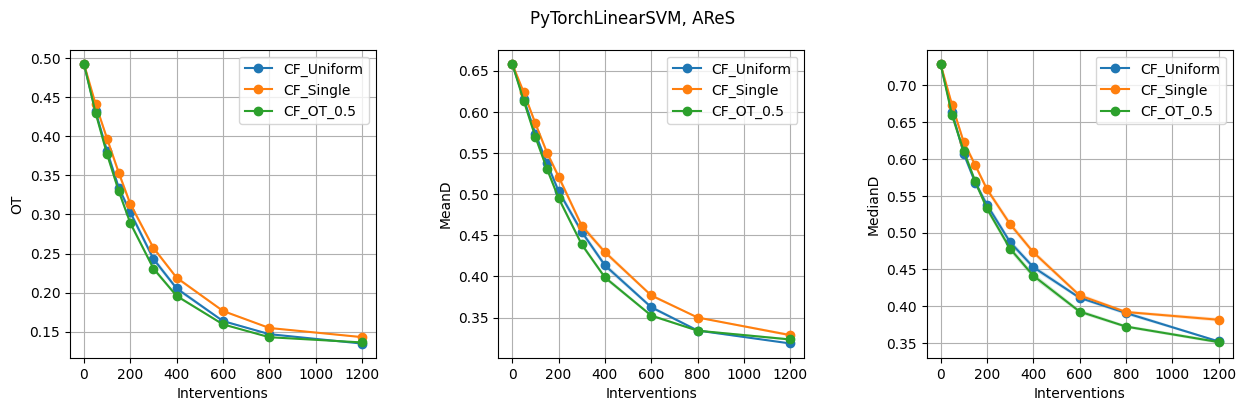

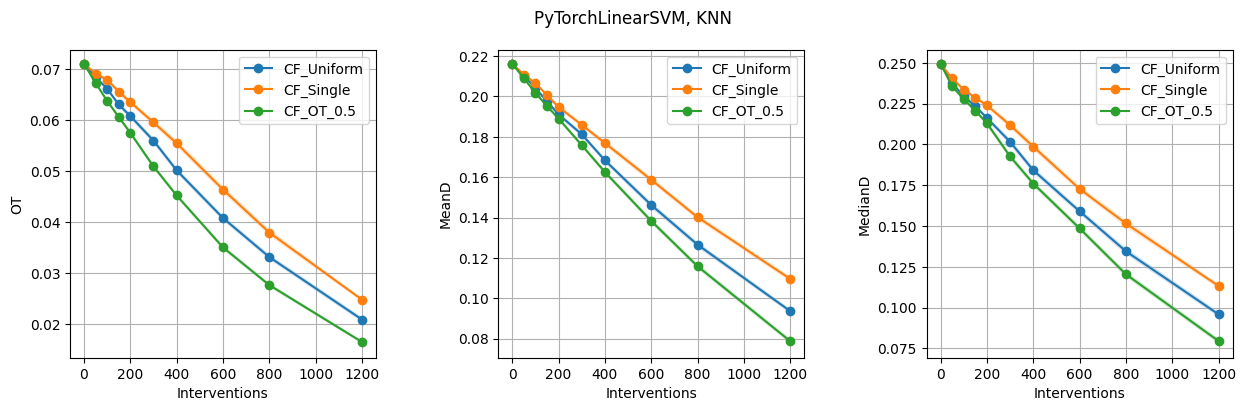

In [31]:
from experiments import plotting

plotting.intervention_vs_distance(experiment, save_to_file=False)